## Implementing Object Detection - YOLO

You Only Look Once (YOLO) is a new and faster approach to object detection. Traditional systems repurposes classifiers to perform detection. Basically to detect any object, the system take a classifier for that object and then classifies its presence at various locations in the image. Other systems generate a potential bounding boxes in an image using region proposal methods and then run a classifier on these potential boxes. This results in a slightly efficient method. After classification, post — processing is used to refine the bounding boxes, eliminate duplicate detection, etc. Due to these complexities the system becomes slow and hard to optimize because each components have to be trained separately.
#### For more information/better understanding visit my blog.
#### Link Part 1: https://medium.com/@pratheesh.27998/object-detection-part1-4dbe5147ad0a
#### Link Part 2: https://medium.com/@pratheesh.27998/object-detection-part2-6a265827efe1

![title](images/cover.png)

## Importing libraries

In [1]:
import os
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image,draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


In [2]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    '''
    box confidence: tensor of shape (19,19,5,1) containing Pc
    boxes: tensor of shape (19,19,5,4)
    box_class_probs: tensor of shape (19,19,5,80)
    threshold: if Pc<threshold, get rid of that box
    '''
    #Computing box scores
    box_scores = box_confidence*box_class_probs
    #Finding the index of the class with maximum box score
    box_classes = K.argmax(box_scores, -1)
    #Getting the corresponding box score
    box_class_scores = K.max(box_scores,-1)
    #Creating a filtering mask. The mask will be true for all the boxes        we intend to keep (pc >= threshold) and false for the rest
    filtering_mask = box_class_scores>threshold
    #Applying the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    '''
    scores: contains class probability score for the selected boxes
    boxes: contains (bx,by,bh,bw) coordinates of selected boxes
    classes: contains the index of class detected by the selected boxes
    '''    
    return scores, boxes, classes

In [3]:
def iou(box1, box2):
    #Calculating (xi1,yi1,xi2,yi2) of the intersection of box1 and box2 
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    #Calculating the area of intersection
    inter_area = (yi2-yi1)*(xi2-xi1)
    #Calculating the areas of box1 and box2 using the same formula
    box1_area = (box1[3] - box1[1])*(box1[2] - box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2] - box2[0])
    #Calculating the union area by using the formula: union(A,B) = A+B-Inter(A,B)
    union_area = box1_area + box2_area - inter_area
    #Calculating iou
    iou = inter_area/union_area
    
    return iou

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    #tensor used in tf.image.non_max_suppression()of size 'max_boxes' 
    max_boxes_tensor = K.variable(max_boxes, dtype = 'int32')
    #initiating the tensor 
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    #Using the tensorflow function tf.image.non_max_suppression to get the indices of boxes kept
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    #Using K.gather to individually access scores, boxes and classes from nms_indices
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [5]:
yolo_outputs = (tf.random_normal([19,19,5,1], mean = 1, stddev = 4, seed = 1),
                tf.random_normal([19,19,5,2], mean = 1, stddev = 4, seed = 1),
                tf.random_normal([19,19,5,2], mean = 1, stddev = 4, seed = 1),
                tf.random_normal([19,19,5,80], mean = 1, stddev = 4, seed = 1))

In [6]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes = 10, score_threshold = .6, iou_threshold = .5):
    '''
    yolo_outputs contains:
    box_confidence, box_xy, box_wh, box_class_probs
    ''' 
    #Retrieving output
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    #Converting the boxes for filtering functions
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    #Using the function defined before to remove boxes with less confidence score
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    #Scaling the boxes
    boxes = scale_boxes(boxes, image_shape)
    #Using the function defined before for non-max suppression
   scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [7]:
scores,boxes,classes = yolo_eval(yolo_outputs)

Tensor("random_normal:0", shape=(19, 19, 5, 1), dtype=float32) Tensor("concat:0", shape=(19, 19, 5, 4), dtype=float32) Tensor("random_normal_3:0", shape=(19, 19, 5, 80), dtype=float32)


In [8]:
with tf.Session() as test_b:
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


#### Now we’re going to test the YOLO pretrained models on images. For this we have to create a session. Also remember that we’re trying to detect 80 classes and using 5 anchor boxes. We have all the class information in “coco_classes.txt” and “yolo_anchors.txt” which must be present in the zip file you downloaded before inside the folder “model_data”.

#### The training of YOLO model takes a long time especially if you don’t have a high spec system. So we are going to load an existing pretrained Keras YOLO model stored in “yolo.h5”. These are the pretrained weights from YOLOv2 model.

#### Lets create a session and load these files.

In [9]:
sess = K.get_session()
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
yolo_model = load_model("model_data/yolo.h5")

C:\Users\Pratheesh\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

#### Now we have to implement a function that runs the graph to test YOLO on an image.

In [11]:
def predict(sess, image_file):
    #Preprocessing the image
    image, image_data = preprocess_image("images/"+image_file, model_image_size = (608,608))
    #Running the session and feeding the input to it
   out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict = {yolo_model.input: image_data, K.learning_phase(): 0})
    #Prints the predicted information
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    #Generates color for drawing bounding boxes
    colors = generate_colors(class_names)
    #Draws bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    #Saving the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality = 150)
    #Displaying the results in notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    plt.figure(figsize=(12,12))
    imshow(output_image)
    return out_scores, out_boxes, out_classes

In [12]:
#Loading the image
img = plt.imread('images/car.jpeg')
#Calculating the size of image and passing it as a parameter to yolo_eval
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Tensor("Sigmoid:0", shape=(?, ?, ?, 5, 1), dtype=float32) Tensor("concat_1:0", shape=(?, ?, ?, 5, 4), dtype=float32) Tensor("Softmax:0", shape=(?, ?, ?, 5, 80), dtype=float32)


Found 1 boxes for car.jpeg
car 0.79 (62, 54) (250, 152)


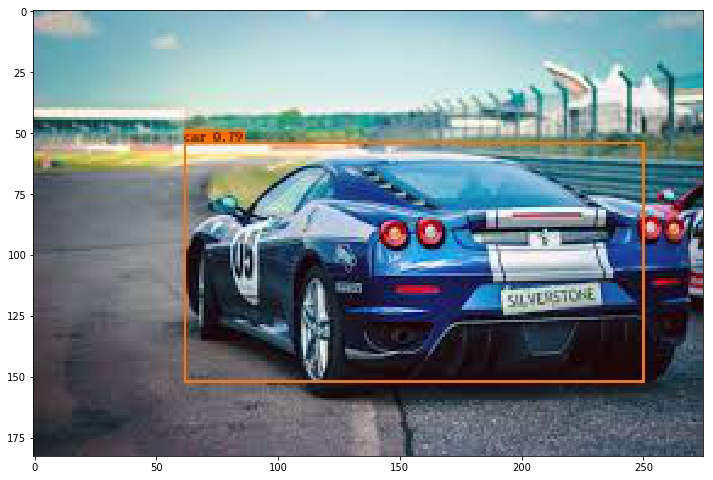

In [53]:
#Predicts the output
out_scores, out_boxes, out_classes = predict(sess, "car.jpeg")

In [63]:
img = plt.imread('images/deadpool.jpg')
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 0 boxes for deadpool.jpg


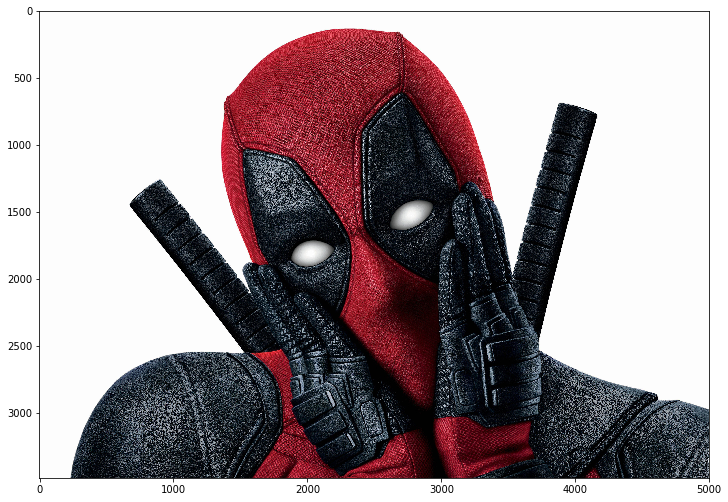

In [64]:
out_scores, out_boxes, out_classes = predict(sess, "deadpool.jpg")

In [65]:
img = plt.imread('images/re.jpg')
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 1 boxes for re.jpg
motorbike 0.93 (254, 583) (1514, 1466)


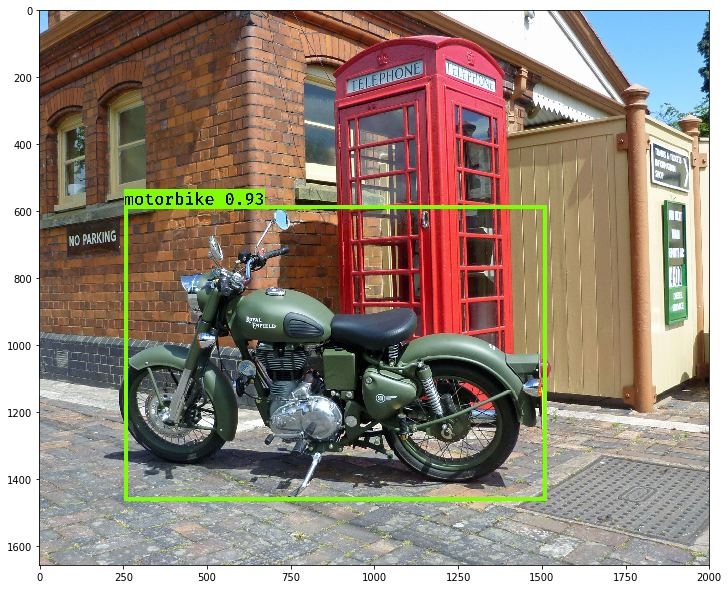

In [66]:
out_scores, out_boxes, out_classes = predict(sess, "re.jpg")

In [67]:
img = plt.imread('images/re1.jpg')
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 1 boxes for re1.jpg
motorbike 0.79 (384, 291) (1781, 1238)


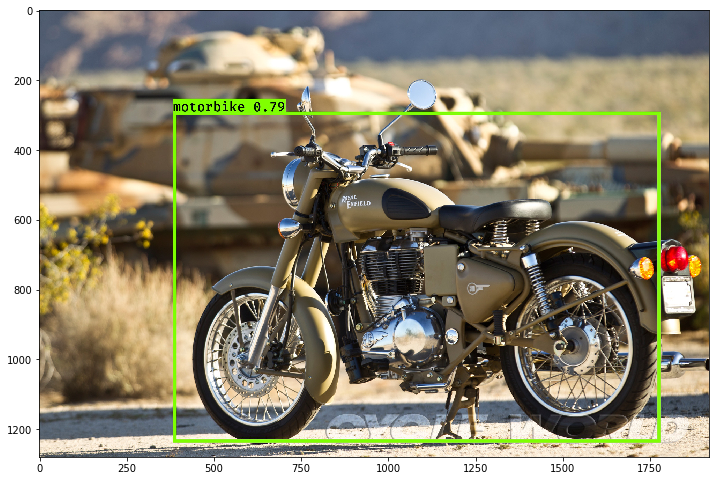

In [68]:
out_scores, out_boxes, out_classes = predict(sess, "re1.jpg")

In [69]:
img = plt.imread('images/boat.jpg')
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 1 boxes for boat.jpg
boat 0.79 (1007, 1757) (3922, 2865)


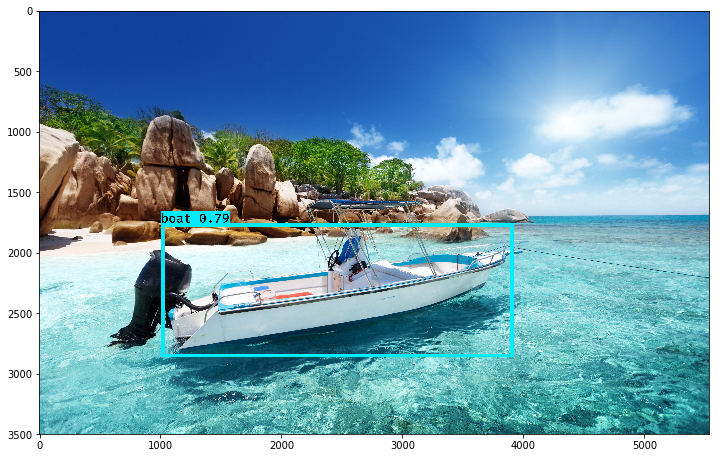

In [70]:
out_scores, out_boxes, out_classes = predict(sess, "boat.jpg")

In [71]:
img = plt.imread('images/f35.jpg')
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 1 boxes for f35.jpg
aeroplane 0.75 (316, 0) (3508, 2622)


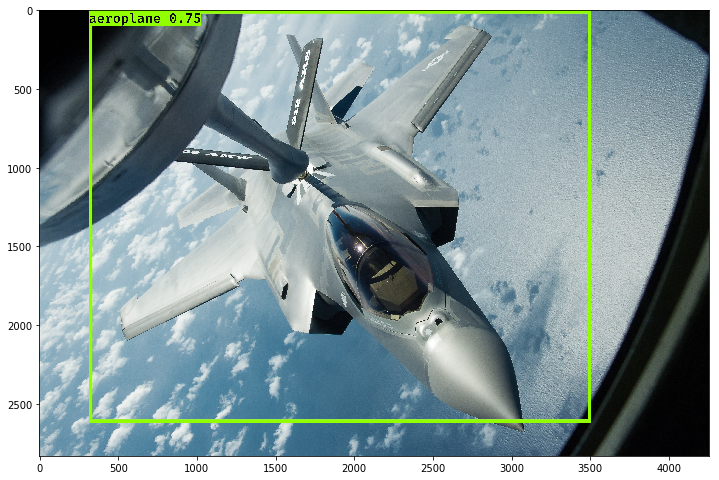

In [73]:
out_scores, out_boxes, out_classes = predict(sess, "f35.jpg")

Found 10 boxes for facebook.jpg
car 0.73 (2, 298) (153, 397)
car 0.75 (734, 298) (902, 352)
person 0.76 (505, 433) (553, 500)
car 0.78 (220, 277) (356, 337)
car 0.78 (505, 218) (655, 279)
car 0.80 (557, 292) (708, 352)
car 0.81 (141, 415) (422, 500)
car 0.82 (320, 303) (499, 372)
car 0.83 (436, 249) (583, 314)
car 0.86 (384, 340) (597, 430)


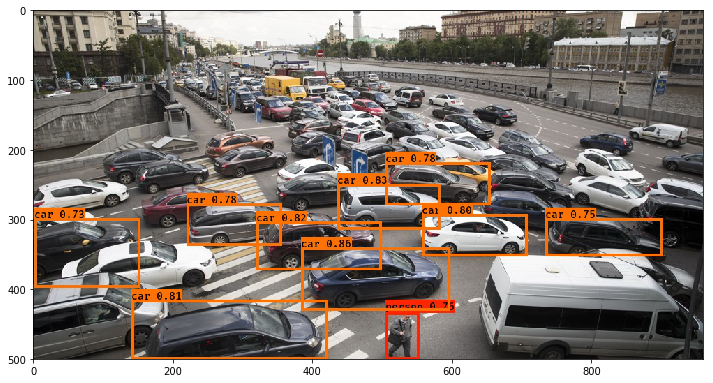

In [78]:
img = plt.imread('images/facebook.jpg')
image_shape = float(img.shape[0]),float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
out_scores, out_boxes, out_classes = predict(sess, "facebook.jpg")